In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
from itertools import chain
import os
import random
import zipfile
plt.style.use("ggplot")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns   #←これを追加
import timm    #←これを追加
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
class CFG:

                       # No. of epochs for training the model
  # Training settings
  batch_size = 25
  epochs = 20
  lr = 3e-5
  gamma = 0.7
  seed = 42                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/root/meidai/data/imgB/ABC20220706-1"




# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [3]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)


In [4]:
from pathlib import Path
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [5]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = Image.open(imgpath).convert(mode="RGB")

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [6]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

GridMask

In [7]:
class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = F.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

AugMix

In [8]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), pil_img.size[0] / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform(pil_img.size,
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)


# operation that overlaps with ImageNet-C's test set
def color(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Color(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def contrast(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Contrast(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def brightness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Brightness(pil_img).enhance(level)


# operation that overlaps with ImageNet-C's test set
def sharpness(pil_img, level):
    level = float_parameter(sample_level(level), 1.8) + 0.1
    return ImageEnhance.Sharpness(pil_img).enhance(level)


augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]

augmentations_all = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y, color, contrast, brightness, sharpness
]

def normalize(image):
    """Normalize input image channel-wise to zero mean and unit variance."""
    return image - 127

def apply_op(image, op, severity):
    #   image = np.clip(image, 0, 255)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img)

def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
    """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image).astype(np.float32)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        # Preprocessing commutes since all coefficients are convex
        mix += ws[i] * image_aug
#         mix += ws[i] * normalize(image_aug)

    mixed = (1 - m) * image + m * mix
#     mixed = (1 - m) * normalize(image) + m * mix
    return mixed


class RandomAugMix(ImageOnlyTransform):

    def __init__(self, severity=3, width=3, depth=-1, alpha=1., always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.severity = severity
        self.width = width
        self.depth = depth
        self.alpha = alpha

    def apply(self, image, **params):
        image = augment_and_mix(
            image,
            self.severity,
            self.width,
            self.depth,
            self.alpha
        )
        return image

In [9]:
import albumentations

In [10]:
train_transformer= albumentations.Compose([
    albumentations.OneOf([
        GridMask(num_grid=3, mode=0, rotate=15),
        GridMask(num_grid=3, mode=2, rotate=15),
    ], p=0.7),
    RandomAugMix(severity=4, width=3, alpha=1.0, p=0.7)
])
test_transformer= transforms.Compose([
    transforms.Resize(CFG.img_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean,std)

])

In [11]:
train=Dataset(train_dir,train_transformer)
test=Dataset(test_dir,test_transformer)

In [12]:
# train_loader = DataLoader(dataset = train, batch_size=CFG.batch_size, shuffle=True ,num_workers=16,pin_memory=True)
# test_loader = DataLoader(dataset = test, batch_size=CFG.batch_size, shuffle=True,num_workers=16,pin_memory=True)

In [13]:
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [14]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=3)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    

In [15]:
# model = ViT(
#     dim=128,
#     image_size=224,
#     patch_size=32,
#     num_classes=3,
#     transformer=efficient_transformer,
#     channels=3,
# ).to(device)

In [16]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)

In [17]:
import time
from tqdm import tqdm
import time
import copy

In [18]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [19]:
classes=['A','B','C']

In [20]:
def train_model(model, criterion, optimizer, scheduler, train_loader,val_loader,train_dataset,valid_dataset,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataloaders = {
        "train":train_loader,
        "val": val_loader
    }
    dataset_sizes = {
        "train":len(train_dataset),
        "val": len(valid_dataset)
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'val':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
def test_eval(model):
  test_loss = 0.0
  correct_num=0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  model.eval()
  test_loader=DataLoader(test,batch_size=CFG.batch_size,num_workers=25)

  for data, target in tqdm(test_loader):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      correct_num+=torch.sum(correct_tensor)
      for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
  test_acc=correct_num/len(test_loader.dataset)
  # print('Test acc: {:.6f}\n'.format(test_acc))
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(classes)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [22]:
import gc

In [23]:
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    test_eval(model)

100%|██████████| 12/12 [00:03<00:00,  3.28it/s]


Test Loss: 0.721884

Test Accuracy of     A: 60% (60/100)
Test Accuracy of     B: 56% (56/100)
Test Accuracy of     C: 80% (80/100)

Test Accuracy (Overall): 65.3333 (196.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.08it/s]


Test Loss: 0.669584

Test Accuracy of     A: 86% (86/100)
Test Accuracy of     B: 49% (49/100)
Test Accuracy of     C: 77% (77/100)

Test Accuracy (Overall): 70.6667 (212.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.11it/s]


Test Loss: 0.703140

Test Accuracy of     A: 95% (95/100)
Test Accuracy of     B: 28% (28/100)
Test Accuracy of     C: 80% (80/100)

Test Accuracy (Overall): 67.6667 (203.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.12it/s]


Test Loss: 0.704282

Test Accuracy of     A: 83% (83/100)
Test Accuracy of     B: 60% (60/100)
Test Accuracy of     C: 69% (69/100)

Test Accuracy (Overall): 70.6667 (212.0/300.0)


100%|██████████| 12/12 [00:03<00:00,  3.13it/s]

Test Loss: 0.691779

Test Accuracy of     A: 55% (55/100)
Test Accuracy of     B: 65% (65/100)
Test Accuracy of     C: 77% (77/100)

Test Accuracy (Overall): 65.6667 (197.0/300.0)


In [24]:
models=[]
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    models.append(model)

In [25]:
def get_all_preds_k_fold(models,loader):
  all_preds=torch.tensor([])
  ground_truth=torch.tensor([])
  running_loss=0
  model1=models[0]
  model2=models[1]
  model3=models[2]
  model4=models[3]
  model5=models[4]
  for batch in loader:
    images,labels=batch
    images=images.to(device)
    labels=labels.to('cpu')

    ground_truth=torch.cat((ground_truth,labels),dim=0)
    p1=model1(images).to('cpu')
    p2=model2(images).to('cpu')
    p3=model3(images).to('cpu')
    p4=model4(images).to('cpu')
    p5=model5(images).to('cpu')
    preds=(p1+p2+p3+p4+p5)/5

    all_preds=torch.cat((all_preds,preds),dim=0)
    loss_val = criterion(preds, labels)
    running_loss += loss_val.item() * images.size(0)
  
  loss=running_loss/len(loader)
  return all_preds,ground_truth,loss

In [26]:
from random import shuffle


with torch.no_grad():
      prediction_loader=torch.utils.data.DataLoader(test,batch_size=len(test),num_workers=16,shuffle=False)
      test_preds,ground_truth,loss=get_all_preds_k_fold(models,prediction_loader)

In [27]:
def get_num_correct(preds,labels):
  print(preds.argmax(dim=1).eq(labels).sum().item()/len(preds))
get_num_correct(test_preds,ground_truth)

0.6566666666666666


In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ground_truth,test_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [29]:

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=30,horizontalalignment="center", color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


/tmp/ipykernel_1232277/63287085.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


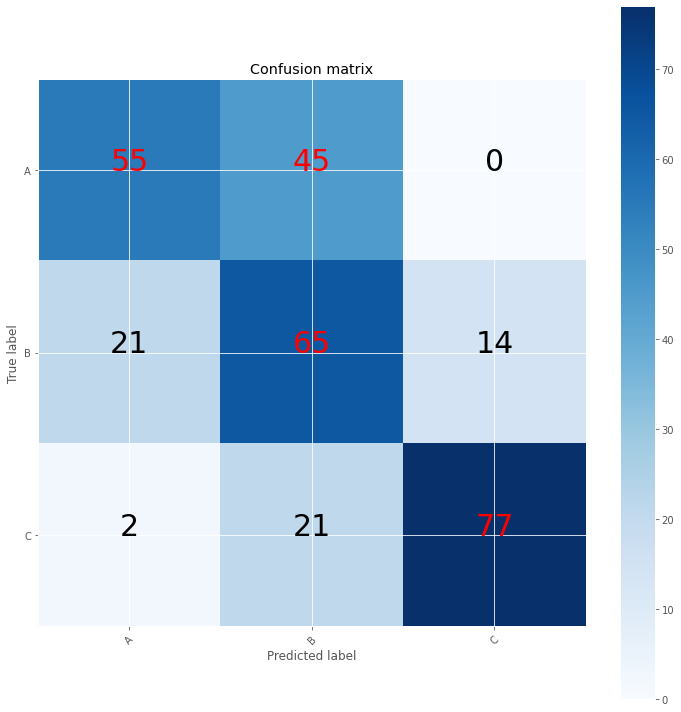

In [30]:
names=('A','B','C')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

各画像での予想確率

In [31]:
prediction=test_preds.argmax(dim=1)

In [32]:
prediction

tensor([1, 2, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2,
        2, 2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 1, 0, 1, 0, 1, 2, 1, 0, 2, 2, 1, 1,
        1, 0, 0, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 0, 1, 0, 2, 1, 2, 0, 1, 1, 0, 2,
        2, 2, 1, 2, 0, 2, 1, 1, 0, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 0, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 0, 2, 0, 0,
        1, 1, 0, 2, 2, 0, 1, 2, 1, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 0,
        1, 1, 1, 1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0, 2, 0, 2,
        2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0, 0, 2, 1, 1, 0, 1, 1, 1,
        2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 0, 1,
        2, 1, 0, 1, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 0,
        1, 1, 2, 0, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2,
        1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2,

In [33]:
m = nn.Softmax(dim=1)
soft_preds=m(test_preds)
soft_preds=m(test_preds)
soft_preds
torch.save(soft_preds, './probability_vit.pt')

In [34]:
testY=ground_truth
len(testY)

300

In [35]:
lst_prob = soft_preds.to('cpu').detach().tolist().copy()
lst_predict = prediction.to('cpu').detach().tolist().copy()
lst_testY = testY.to('cpu').detach().tolist().copy()
answer_dict={'真の値':lst_testY,'Vitによる予測値(ラベル)':prediction,'Vitによる予測値(確率)':lst_prob}
answer_csv=pd.DataFrame(answer_dict)

In [36]:
answer_csv=pd.read_csv('/root/meidai/pragram/pytorch/code/Effinet/Eff2_kfold2_Randomcrop+flip/ground_truth_vs_prediction_eff.csv',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/root/meidai/pragram/pytorch/code/Effinet/Eff2_kfold2_Randomcrop+flip/ground_truth_vs_prediction_eff.csv'

In [ ]:
answer_csv

,真の値,effinetによる予測値
0,0,0
1,2,2
2,1,1
3,2,1
4,0,1
...,...,...
295,0,1
296,1,0
297,1,2
298,2,2


In [ ]:
answer_csv['Vitによる予測値']=prediction

In [ ]:
answer_csv

,真の値,effinetによる予測値,Vitによる予測値
0,0,0,0
1,2,2,2
2,1,1,1
3,2,1,1
4,0,1,1
...,...,...,...
295,0,1,1
296,1,0,0
297,1,2,2
298,2,2,2


In [ ]:
answer_csv.to_csv('./ground_truth_vs_prediction_vit_eff.csv')

In [ ]:
error ={"AB":[],
        "AC":[],
        "BA":[],
        "BC":[],
        "CA":[],
        "CB":[]}

for i in range(len(prediction)):
    if prediction[i]!= testY[i]:
        if (testY[i]==0)and(prediction[i]==1):
            error["AB"].append(test_dir[i])
        elif (testY[i]==0)and(prediction[i]==2):
            error["AC"].append(test_dir[i])
        elif (testY[i]==1)and(prediction[i]==0):
            error["BA"].append(test_dir[i])
        elif (testY[i]==1)and(prediction[i]==2):
            error["BC"].append(test_dir[i])
        elif (testY[i]==2)and(prediction[i]==0):
            error["CA"].append(test_dir[i])
        elif (testY[i]==2)and(prediction[i]==1):
            error["CB"].append(test_dir[i])


In [ ]:
print(len(error['AB']),
len(error['AC']),
len(error['BA']),
len(error['BC']),
len(error['CA']),
len(error['CB']))



20 1 32 14 5 12


In [ ]:
import cv2

In [ ]:
for i in error:
    print(error[i])

['/root/meidai/data/imgB/ABC20220706-1/A/m111.1.11.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h33.47.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h27.15.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h28.49.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m111.1.30.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m111.2.19.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h28.07.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h28.12.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h27.38.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m113.1.11.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m111.1.09.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m111.1.44.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h28.46.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m111.2.31.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m111.1.58.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h31.58.tif', '/root/meidai/data/imgB/ABC20220706-1/A/m113.1.17.tif', '/root/meidai/data/imgB/ABC20220706-1/A/h33.23.tif', '/root/meidai/data

In [ ]:
error['AB'][0][39:-3]

'm111.1.11.'

In [ ]:
CFG.ds_path

'/root/meidai/data/imgB/ABC20220706-1'

In [ ]:
def copy(ABC, dict):
    for path in dict[ABC]:
        img_path = path[39:-3]
        img=cv2.imread(path)
        img = cv2.resize(img,(480,360))
        dir_path='/root/meidai/pragram/pytorch/code/ViT/VIT6(各epochで最小のloss保存)/error_ViT/'+ABC+'/'
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        cv2.imwrite(dir_path+img_path+'.png',img)# c

In [ ]:
for i in error:
    copy(i,error)

In [ ]:
import cv2

for idx,path in enumerate(test_dir):
    dir_path='./test_data_tif/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    img=cv2.imread(path)
    # img = cv2.resize(img,(480,360))
    cv2.imwrite(dir_path+str(idx)+'.tif',img)   

In [ ]:
len(os.listdir('./test_data/'))

300

In [ ]:
def image_loader(image_name):
    image = Image.open(image_name).convert("RGB")
    image = test_transformer(image)
    # image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image.cuda()

m = nn.Softmax(dim=1)


In [ ]:
prediction

tensor([0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2,
        2, 2, 1, 1, 0, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1,
        1, 0, 0, 1, 2, 2, 1, 0, 1, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2,
        2, 2, 0, 2, 0, 2, 1, 1, 0, 0, 2, 0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 2, 0, 0,
        0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 0,
        1, 1, 0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 0, 2, 1, 2, 0, 2, 1, 0,
        0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 0, 0, 2, 0, 2,
        2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 2, 0, 0, 2, 1, 2, 0, 1, 1, 1,
        2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 2,
        1, 2, 0, 1, 2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 2, 0,
        1, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 2, 2, 2, 2,
        0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 2,

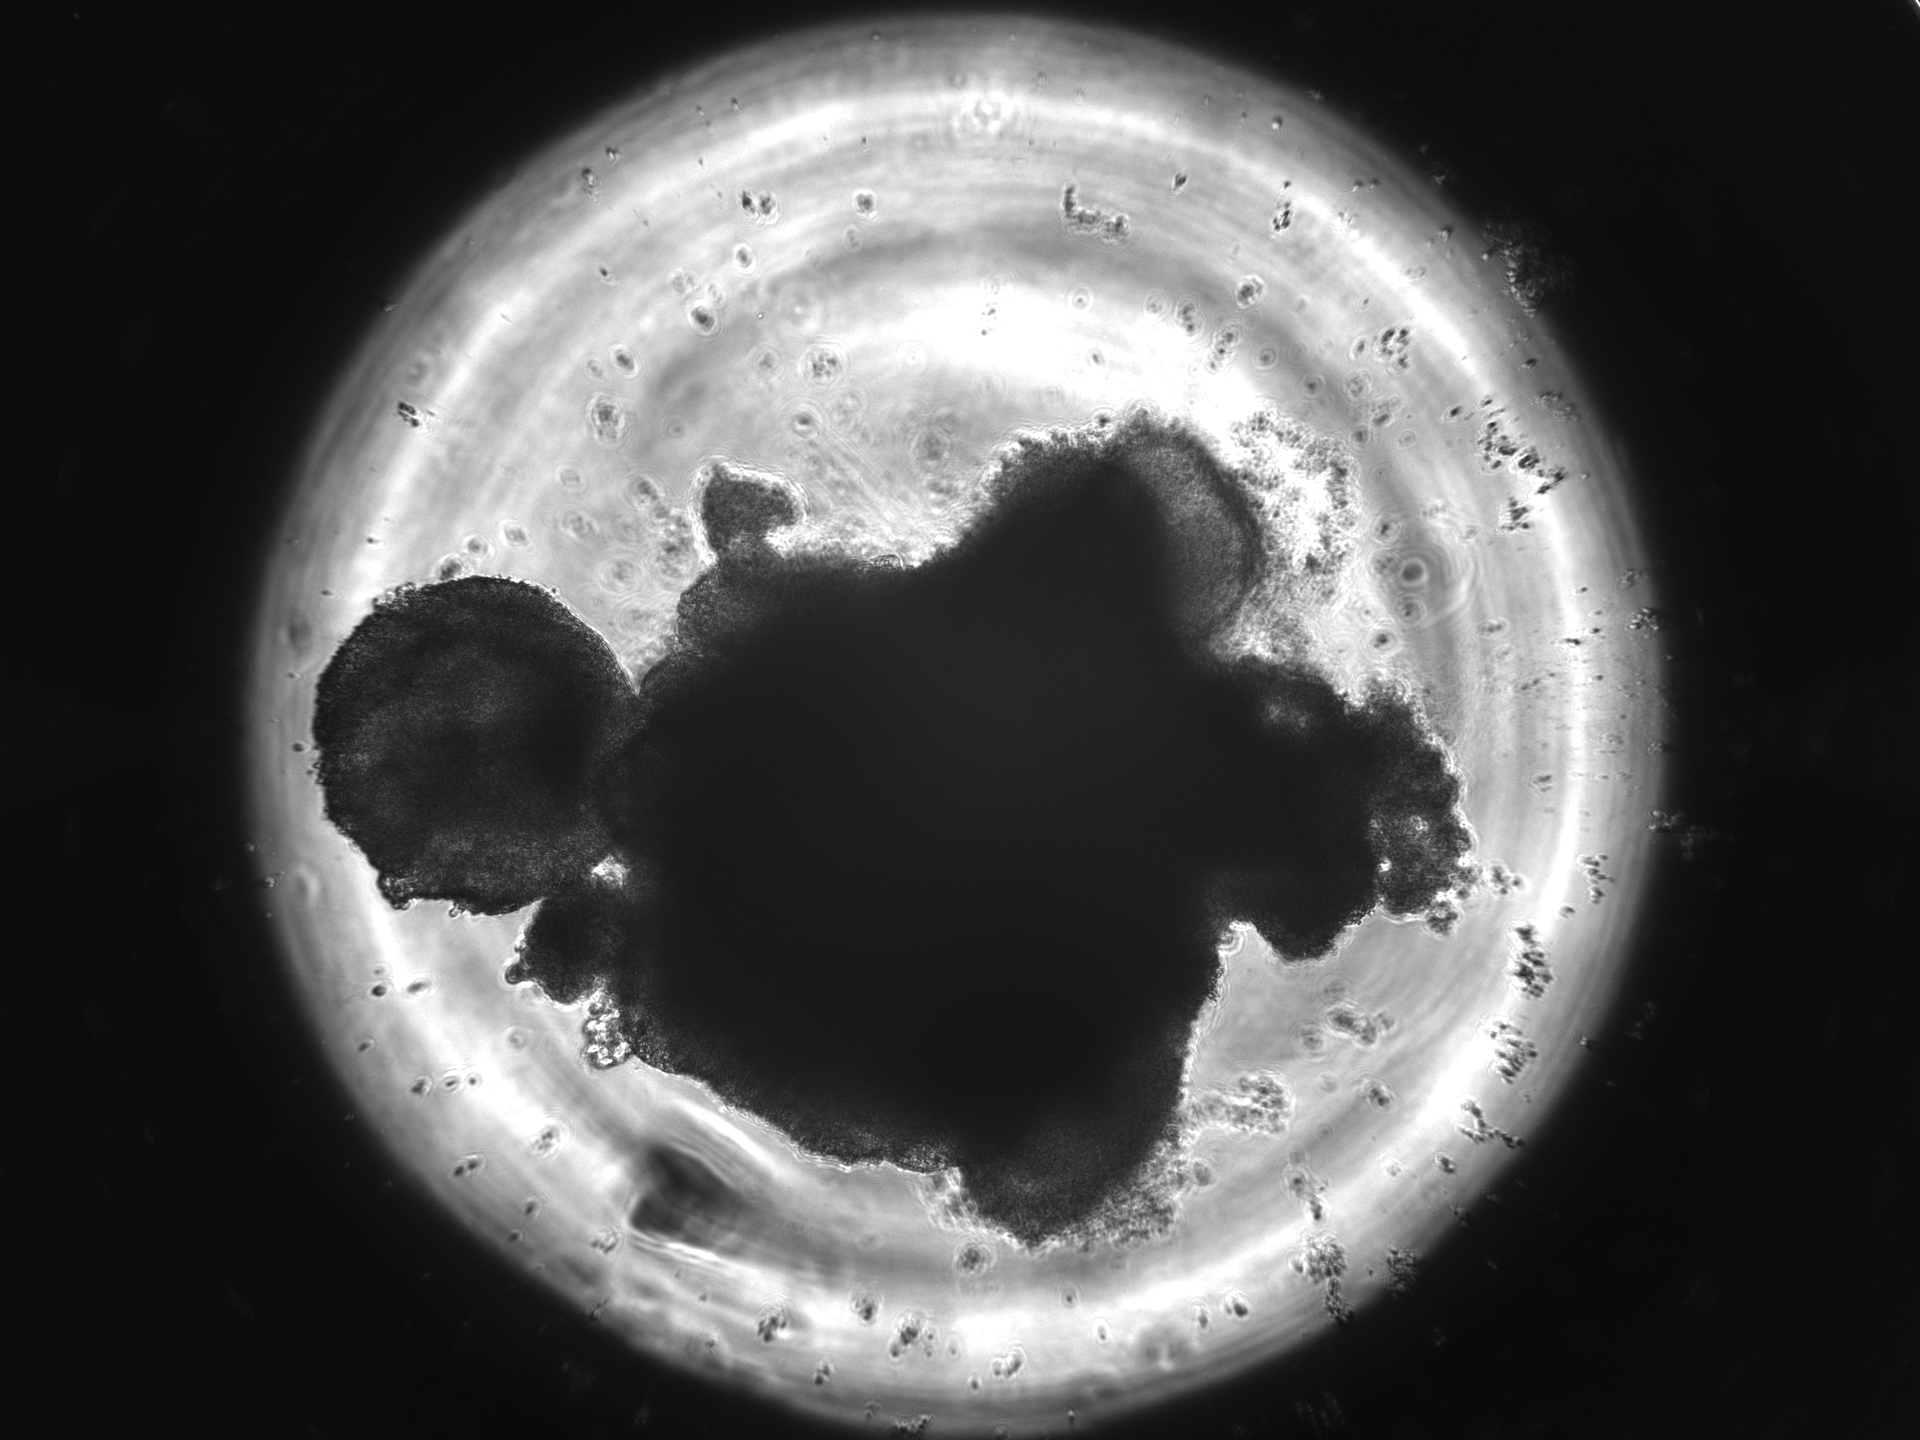

tensor([[ 1.6112, -0.0157, -2.3279]], grad_fn=<DivBackward0>)

In [ ]:
cell_image_path = os.path.join('/root/meidai/pragram/pytorch/code/ViT/VIT6_minimun_loss__in_each_epoch/test_data_tif', '0.tif')
predicted_cell_image = image_loader(cell_image_path)
# print(type(predicted_cell_image))
display(Image.open(cell_image_path))
model1=models[0]
model2=models[1]
model3=models[2]
model4=models[3]
model5=models[4]
p1=model1(predicted_cell_image.float()).to('cpu')
p2=model2(predicted_cell_image.float()).to('cpu')
p3=model3(predicted_cell_image.float()).to('cpu')
p4=model4(predicted_cell_image.float()).to('cpu')
p5=model5(predicted_cell_image.float()).to('cpu')
preds=(p1+p2+p3+p4+p5)/5
preds

In [ ]:
test_preds

tensor([[ 1.6110e+00, -1.5288e-02, -2.3280e+00],
        [-3.2185e+00, -6.2033e-02,  4.6363e+00],
        [ 2.5999e-01,  1.6162e+00, -9.8666e-01],
        [-1.7019e+00,  1.8173e+00,  5.7463e-01],
        [ 3.0992e-01,  1.6745e+00, -1.0933e+00],
        [ 1.3277e+00,  1.9634e-01, -1.6450e+00],
        [-1.4572e+00,  2.6016e+00,  6.7644e-01],
        [-3.1917e+00,  2.8009e-01,  3.4893e+00],
        [ 1.4024e+00,  7.4870e-01, -1.8505e+00],
        [-2.9562e+00,  1.3983e+00,  2.7350e+00],
        [-3.4254e+00,  1.3938e+00,  3.2916e+00],
        [ 1.3967e+00, -5.6674e-02, -1.7789e+00],
        [ 1.0151e+00,  9.3229e-01, -1.8789e+00],
        [ 1.0114e-01,  8.0052e-01, -1.0268e+00],
        [-7.2726e-01,  1.2111e+00, -7.7833e-03],
        [-5.5264e-01,  1.6621e+00, -8.1050e-01],
        [-2.9796e+00,  6.0739e-01,  4.6790e+00],
        [-2.6250e+00,  2.0901e+00,  3.0632e-01],
        [-2.8969e+00,  2.7296e+00,  1.5525e+00],
        [-3.4325e+00,  1.0389e+00,  2.0182e+00],
        [-2.6751e+00